In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Task 01

In [2]:
# Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch 1/10, Loss: 2.3025598993301393
Epoch 2/10, Loss: 2.3025634944438935
Epoch 3/10, Loss: 2.3025655169487
Epoch 4/10, Loss: 2.3025671491622925
Epoch 5/10, Loss: 2.3025697391033173
Epoch 6/10, Loss: 2.3025711081027986
Epoch 7/10, Loss: 2.302572984457016
Epoch 8/10, Loss: 2.302574281454086
Epoch 9/10, Loss: 2.3025756072998047
Epoch 10/10, Loss: 2.3025770733356477


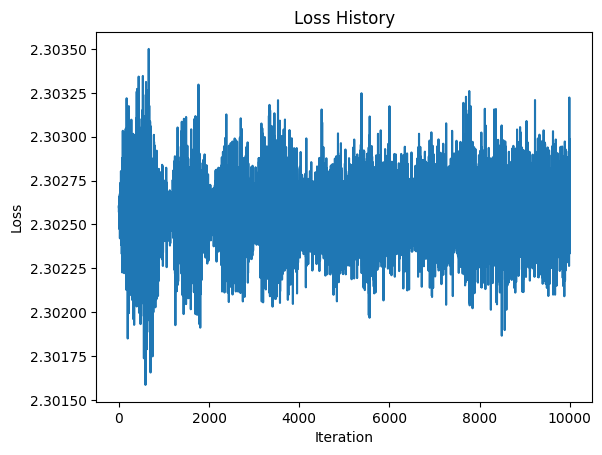

Training Accuracy: 10.00%
Test Accuracy: 10.00%


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Number of nodes in the hidden layer
K = 10  # Number of classes (output size)
std = 1e-5

# Initialize weights and biases for two layers
w1 = torch.randn(Din, H) * std  # First layer weights
b1 = torch.zeros(H)  # First layer biases
w2 = torch.randn(H, K) * std  # Second layer weights
b2 = torch.zeros(K)  # Second layer biases

# Hyperparameters
iterations = 10
lr = 2e-6  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []

# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # One-hot encoding of labels

        # Forward pass with hidden layer activation (Sigmoid)
        h = torch.sigmoid(x_train.mm(w1) + b1)  # Sigmoid activation on hidden layer
        y_pred = h.mm(w2) + b2  # Output layer

        # Cross-Entropy Loss (using nn.CrossEntropyLoss)
        loss = torch.nn.functional.cross_entropy(y_pred, labels) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = torch.nn.functional.one_hot(labels, K).float() - torch.softmax(y_pred, dim=1)
        dw2 = h.t().mm(dy_pred)
        db2 = dy_pred.sum(dim=0)
        dh = dy_pred.mm(w2.t()) * h * (1 - h)
        dw1 = x_train.t().mm(dh)
        db1 = dh.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for each epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

# Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 4. Calculate Accuracy on Training Set
def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            Ntr = inputs.shape[0]
            x_train = inputs.view(Ntr, -1)  # Flatten input
            h = torch.sigmoid(x_train.mm(w1) + b1)  # Sigmoid activation on hidden layer
            y_pred = h.mm(w2) + b2  # Output layer
            predicted = torch.argmax(y_pred, dim=1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_acc = calculate_accuracy(trainloader)
test_acc = calculate_accuracy(testloader)
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

## Task 02

In [5]:
# 1. Dataloading for MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 50

# MNIST dataset for training and testing
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:


# 2. Define the LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input: 1 channel, Output: 6 channels, Kernel: 5x5
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer with kernel size 2 and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input: 6 channels, Output: 16 channels, Kernel: 5x5
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Flatten to 120 nodes
        self.fc2 = nn.Linear(120, 84)  # Fully connected layer with 84 nodes
        self.fc3 = nn.Linear(84, 10)  # Output layer with 10 classes for MNIST

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
        x = x.view(-1, 16 * 4 * 4)  # Flatten the input for fully connected layers
        x = torch.relu(self.fc1(x))  # Fully connected layer 1 with ReLU activation
        x = torch.relu(self.fc2(x))  # Fully connected layer 2 with ReLU activation
        x = self.fc3(x)  # Output layer
        return x

# 3. Initialize the Network
net = LeNet5()

# 4. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # Stochastic gradient descent optimizer

# 5. Training Loop
num_epochs = 10
loss_history = []
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss / 200:.4f}')
            running_loss = 0.0

print('Finished Training')

# 6. Calculate Accuracy on the Test Set
correct = 0
total = 0
with torch.no_grad():  # Turn off gradients for inference
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {test_accuracy:.2f}%')

# 7. Calculate Accuracy on the Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

train_accuracy = 100 * correct_train / total_train
print(f'Accuracy of the network on the training set: {train_accuracy:.2f}%')



Epoch [1/10], Step [200/1200], Loss: 2.2976
Epoch [1/10], Step [400/1200], Loss: 2.2728
Epoch [1/10], Step [600/1200], Loss: 2.1262
Epoch [1/10], Step [800/1200], Loss: 1.0713
Epoch [1/10], Step [1000/1200], Loss: 0.5475
Epoch [1/10], Step [1200/1200], Loss: 0.4432
Epoch [2/10], Step [200/1200], Loss: 0.3580
Epoch [2/10], Step [400/1200], Loss: 0.3117
Epoch [2/10], Step [600/1200], Loss: 0.2652
Epoch [2/10], Step [800/1200], Loss: 0.2358
Epoch [2/10], Step [1000/1200], Loss: 0.2206
Epoch [2/10], Step [1200/1200], Loss: 0.1823
Epoch [3/10], Step [200/1200], Loss: 0.1741
Epoch [3/10], Step [400/1200], Loss: 0.1610
Epoch [3/10], Step [600/1200], Loss: 0.1493
Epoch [3/10], Step [800/1200], Loss: 0.1505
Epoch [3/10], Step [1000/1200], Loss: 0.1406
Epoch [3/10], Step [1200/1200], Loss: 0.1334
Epoch [4/10], Step [200/1200], Loss: 0.1252
Epoch [4/10], Step [400/1200], Loss: 0.1192
Epoch [4/10], Step [600/1200], Loss: 0.1191
Epoch [4/10], Step [800/1200], Loss: 0.1096
Epoch [4/10], Step [1000/1

## Task 03

In [9]:
import os
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import zipfile
from urllib import request

# 1. Download and Extract Hymenoptera Dataset
data_dir = './hymenoptera_data'

# Dataset download URL
dataset_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

# Download the zip file
zip_file_path = './hymenoptera_data.zip'
request.urlretrieve(dataset_url, zip_file_path)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('./')

# Check if dataset is extracted
if os.path.exists(data_dir):
    print("Dataset downloaded and extracted.")
else:
    print("Error in downloading or extracting the dataset.")


Dataset downloaded and extracted.


In [11]:
# 2. Define Data Transformations for Hymenoptera Dataset
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize images to 224x224 (ResNet input size)
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
}

# 3. Load the Hymenoptera Dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}


In [12]:
# 4. Initialize the Pre-trained ResNet-18 Model
model = models.resnet18(pretrained=True)

# Modify the final layer for Hymenoptera classification (2 classes: ants, bees)
num_ftrs = model.fc.in_features  # Get the number of features in the final fully connected layer
model.fc = torch.nn.Linear(num_ftrs, 2)  # Change output layer to 2 (ants and bees)

# 5. Define Loss Function and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Fine-Tuning the Model (Training)
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model to training mode
            else:
                model.eval()   # Set the model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 8. Train the Model
model_ft = train_model(model, criterion, optimizer, num_epochs=10)

# 9. Save the Model
torch.save(model_ft.state_dict(), 'best_resnet18_hymenoptera.pth')

# 10. Evaluate the Model on the Test Set (Validation)
model_ft.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy on Validation Set: {100 * correct / total:.2f}%')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch 1/10
----------
train Loss: 0.7292 Acc: 0.5287
val Loss: 0.5116 Acc: 0.7908

Epoch 2/10
----------
train Loss: 0.5015 Acc: 0.7869
val Loss: 0.2854 Acc: 0.9477

Epoch 3/10
----------
train Loss: 0.3148 Acc: 0.8730
val Loss: 0.2175 Acc: 0.9281

Epoch 4/10
----------
train Loss: 0.2544 Acc: 0.9098
val Loss: 0.1838 Acc: 0.9412

Epoch 5/10
----------
train Loss: 0.2534 Acc: 0.8811
val Loss: 0.1592 Acc: 0.9608

Epoch 6/10
----------
train Loss: 0.1765 Acc: 0.9221
val Loss: 0.1536 Acc: 0.9477

Epoch 7/10
----------
train Loss: 0.1431 Acc: 0.9590
val Loss: 0.1522 Acc: 0.9477

Epoch 8/10
----------
train Loss: 0.1355 Acc: 0.9631
val Loss: 0.1479 Acc: 0.9412

Epoch 9/10
----------
train Loss: 0.1586 Acc: 0.9426
val Loss: 0.1483 Acc: 0.9412

Epoch 10/10
----------
train Loss: 0.1221 Acc: 0.9549
val Loss: 0.1452 Acc: 0.9542

Training complete in 5.0m 51.70402693748474s
Best val Acc: 0.9608
Final Accuracy on Validation Set: 95.42%
